# Классификация мебели внутри интерьера с помощью нейросети, дообученной на синтетических данных

**Описание проекта:**

Целью данного проекта является создание рабочей нейросети для классификации видов мебели на снимках интерьера, по заданию для обучения модели требуется подготовить синтетический датасет из 1000 изображений, на котором нужно дообучить предобученную нейросеть.


**Состав проекта:**

Данный проект можно условно поделить на две задачи: 
- создание датасета
- создание нейросети
<br></br>

Таким образом, состав проекта следующий:
1. **Создание датасета**
  - создание 3D модели интерьера в Unity
  - настройка рандомизации положения камеры с помощью модуля Unity Perception и кастомных скриптов
  - настройка аннотации изображений (всего 3 класса мебели - стул, стол, диван)
  - настройка сценария и создание датасета
  - перевод датасета в формат Common Objects in Context (COCO)
 
2. **Создание нейросети**
 - создание нейросети на основе CNN в Pytorch с выходными нейронами согласно числу классов (всего классов получилось 7, так как решаем задачу классификации объектов: 3 класса одиночных предметов, еще 3 класса их комбинаций типа "стол + стул", один класс для случаев, когда все три типа находятся в кадре)
 - тестирование нейросети на реальных изображениях интерьеров

<h2>Создание датасета</h2>


<h3>Создание модели интерьера в Unity</h3>

С помощью программы 3dsMax я создала комнату с окнами и назначила ей материалы. Затем, с помощью экспорта в формат .fbx она была перенесена в Unity. Далее путем загрузки моделей мебели в 3DsMax, экспорта их в .fbx и импорта их в Unity были размещены предметы мебели. 

При выполнении данной задачи я столкнулась с трудностями поддержки некоторых материалов и текстур - их пришлось заново назначать в Unity, формат .fbx, к сожалению, не позволил произвести импорт чисто.

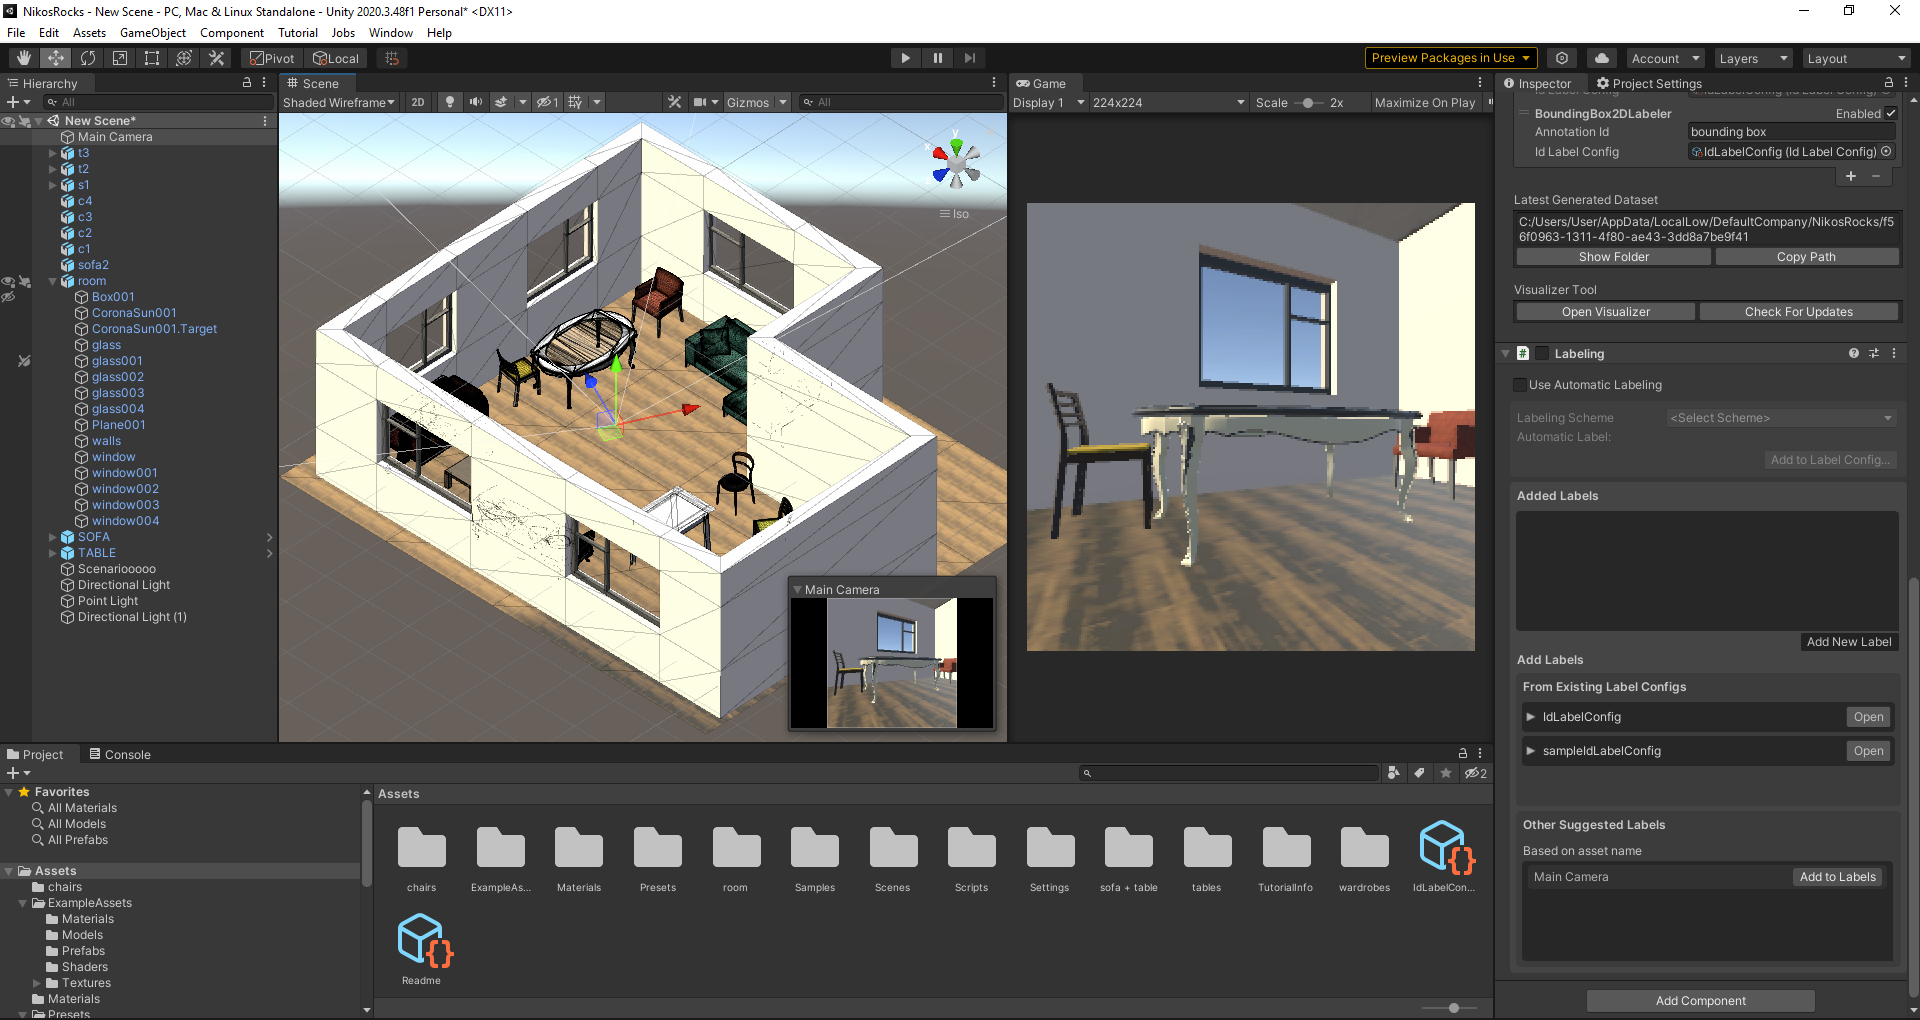

<h3>Настройка рандомизации положения камеры</h3>

Далее с помощью модуля **Unity Perception** я назначила камеру, установила рандомизацию камеры, создала сценарий ее перемещения и формат выходных изображений 224px x 224px. Модуль **Perception** позволяет также настроить рандомизацию цветов предметов, в данном случае применяю рандомизацию цвета стен и мебели.

*Скрипт настройки поворота камеры:*
```c#
using System;
using System.Collections;
using System.Collections.Generic;
using UnityEngine;
using UnityEngine.Perception.Randomization.Parameters;
using UnityEngine.Perception.Randomization.Randomizers;

[Serializable]
[AddRandomizerMenu("Perception/Camera Randomizer2")]

public class CameraRandomizer2 : Randomizer
{
    public FloatParameter cameraYRotation;
    public Camera mainCamera;

    protected override void OnIterationStart()
    {
        var elevation = cameraYRotation.Sample();

        mainCamera.transform.rotation = Quaternion.Euler(0f, elevation, 0f);
        
    }
}
```

<h3>Настройка аннотации изображений</h3>

В Perception имеются несколько режимов аннотации изображений - создание BoundingBox, масок для сегментации изображений. Для конкретной задачи классификации был выбран **BoundingBox2DLabeler**, в котором я указала три класса - `table`, `sofa`, `chair`.

Итогом работы данного лейблера стал json-файл, в котором были указаны классы предметов, находящихся в кадре, и координаты описывающих их прямоугольников.

Ниже приведена схема устройства аннотации файлов в Unity Perception:

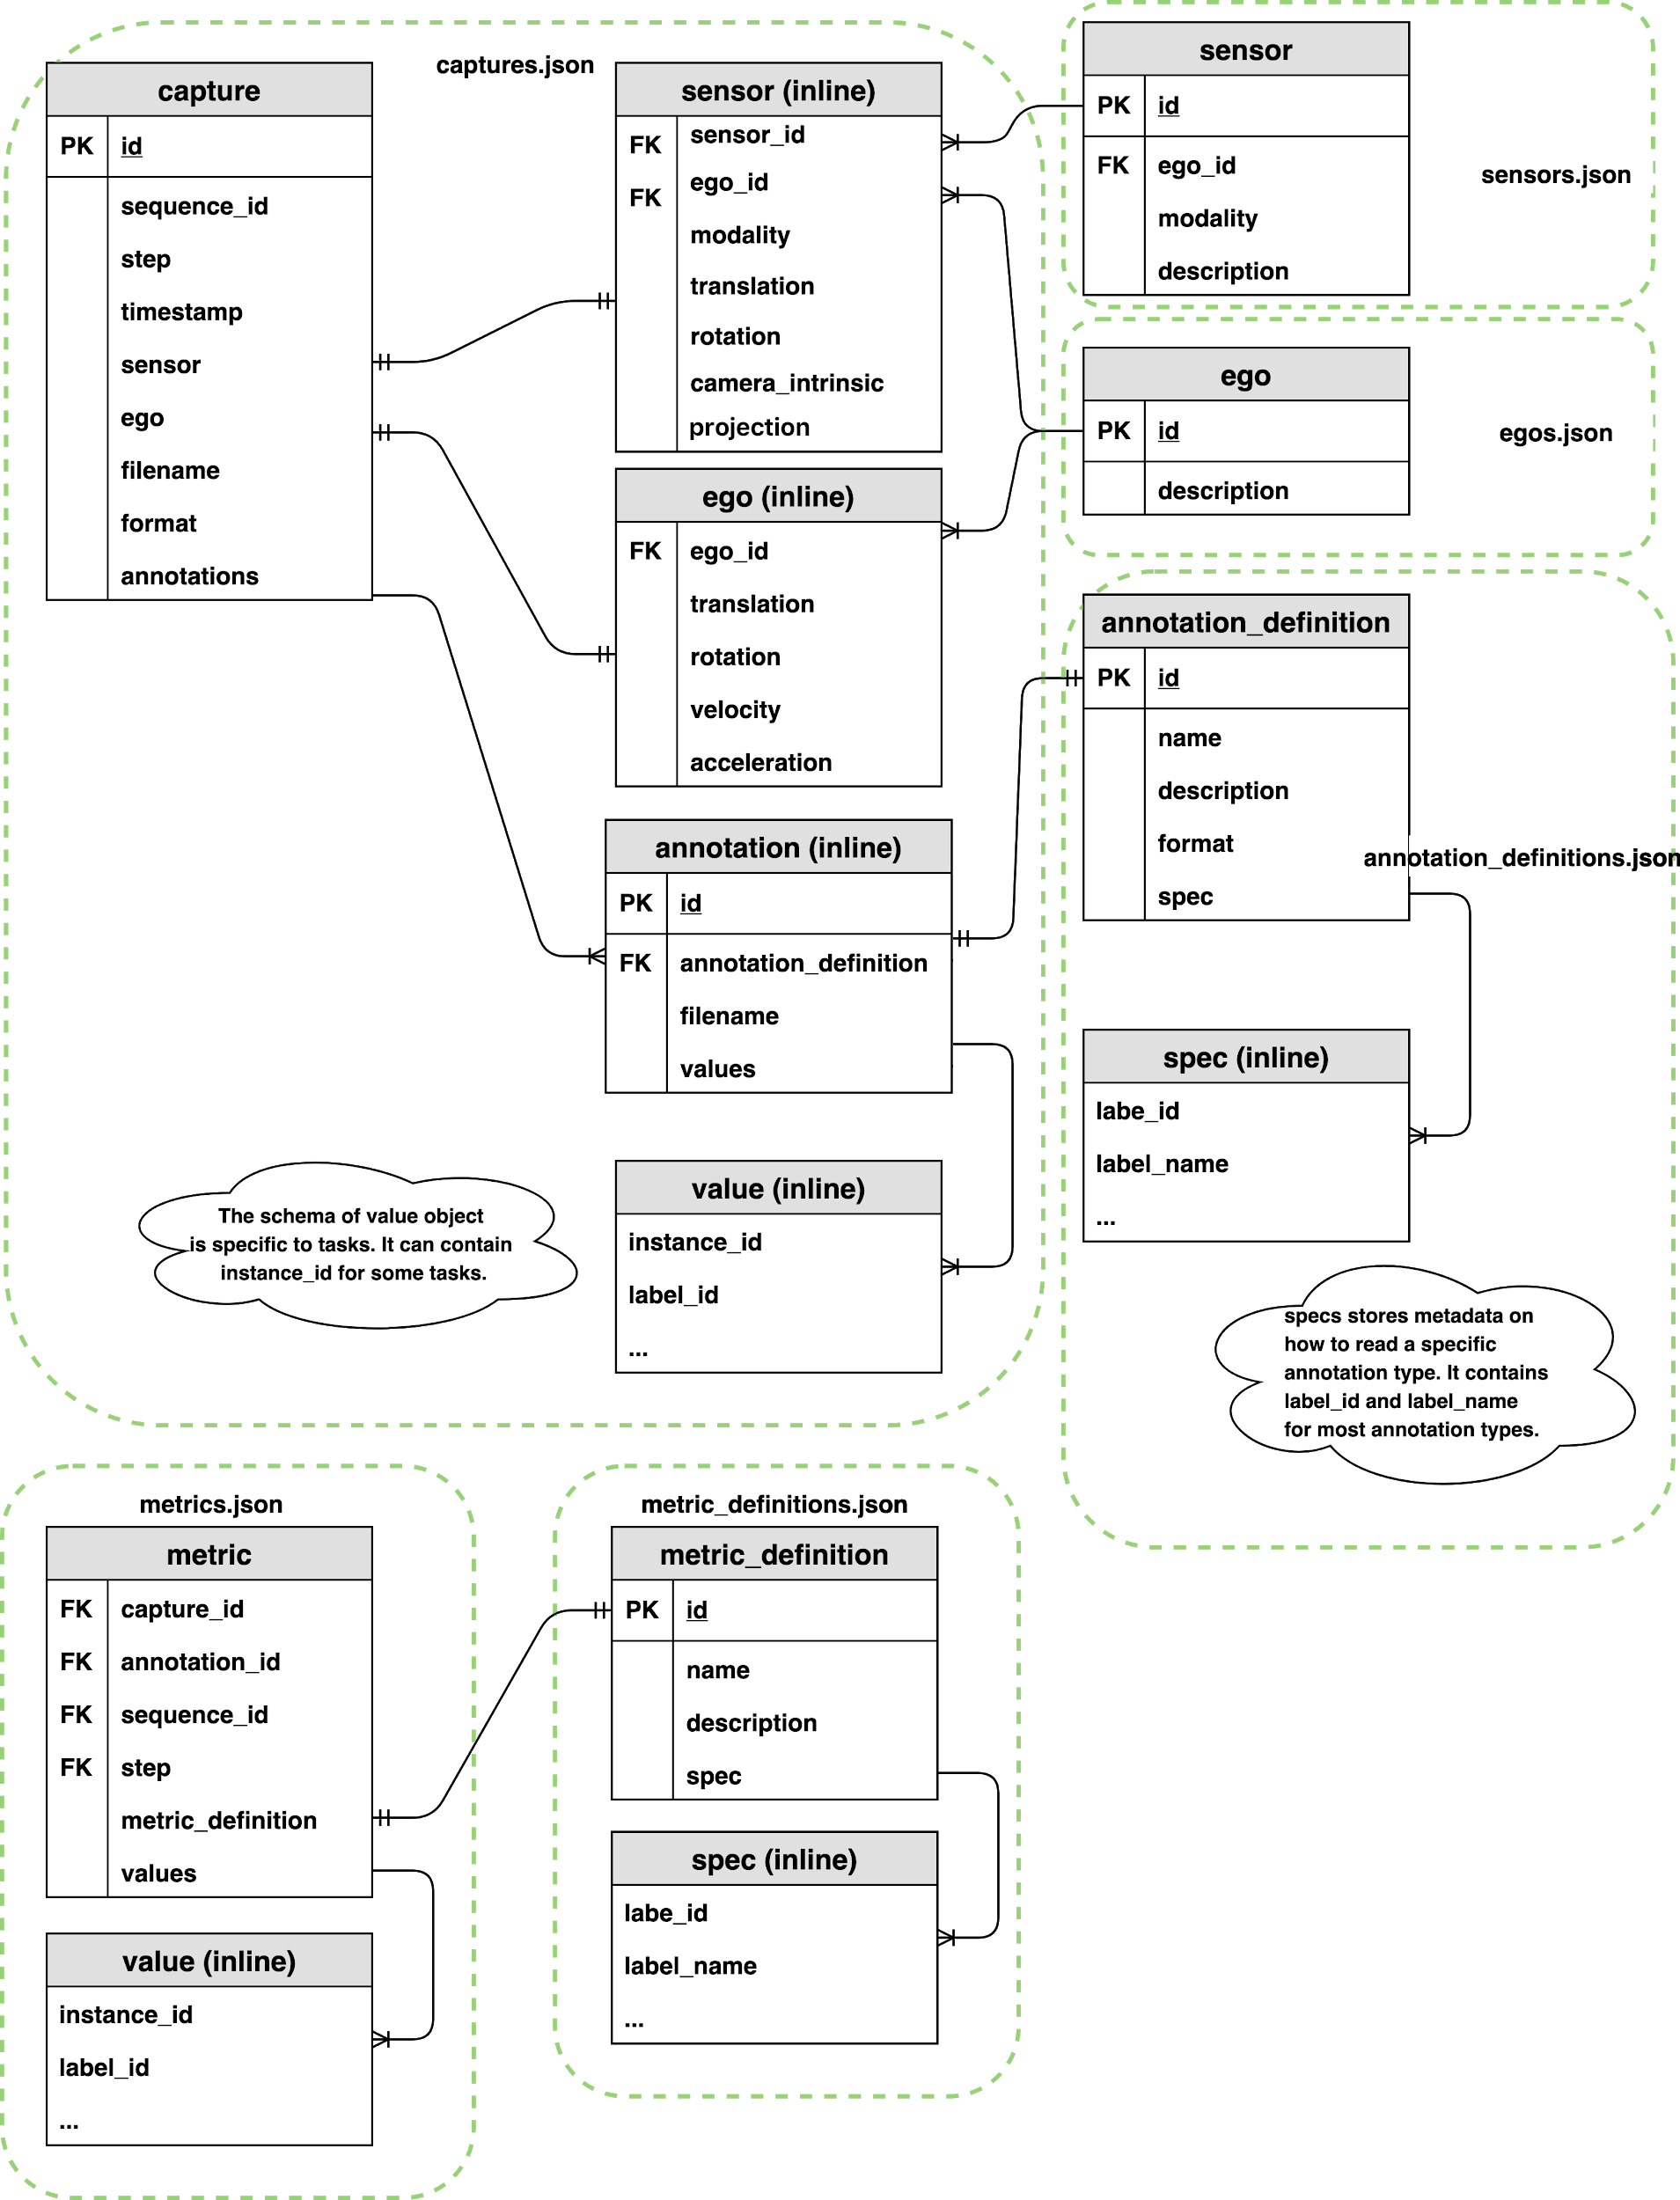

Результатом работы с Unity стал датасет с трехканальными цветными rgb-изображениями разных ракурсов интерьера с мебелью внутри в количестве 1000 штук и файлы аннотаций в формате json.
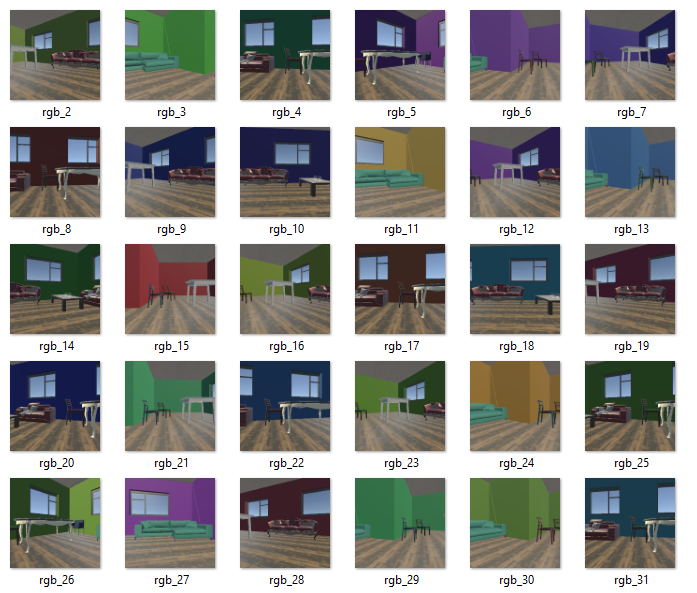

<h3>Конвертация датасета в формат Common Objects in Context (COCO)</h3>

Для выполнения данной процедуры были опробованы несколько инструментов. Успешным оказался [код](https://github.com/lessw2020/perception_tools/blob/main/perception_to_coco.ipynb) с просторов гитхаб:

In [11]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [12]:
from pathlib import Path, PurePath
Path.cwd()

WindowsPath('C:/Users/User/Desktop/mindset')

In [13]:
import json
from copy import deepcopy
import os
from datetime import datetime as dt

In [26]:
def require_dir(item, type="Dataset"):
    itemp = Path(item)
    if not itemp.is_dir():
        raise ValueError(f"directory of type {type} not found. aborting...")

def get_sub_folders(upper_path):
    # verify upper path
    fpath = Path(upper_path)
    
    require_dir(fpath, "Perception root dir")  # will break with raise error if not dir
    
    # get required subfolders
    # dataset
    #subdirs = [f.path for f in os.scandir(upper_path) if f.is_dir() ]
    
    dataset_glob = fpath.glob("Dataset*")
    try:
        dataset_dir = next(dataset_glob) 
    except StopIteration:
        print(f"** failed to get Dataset dir. aborting..")
        return None, None
    
    require_dir(dataset_dir, "Dataset")
    
    print(f"--> using {dataset_dir.name} to generate annotations")
    
    image_glob = fpath.glob("RGB*")
    
    try:
        image_dir = next(image_glob)
    except StopIteration:
        print(f"** failed to get an image dir. aborting...")
        return None, None
        
    
    print(f"--> using {image_dir.name} for images")
    
    
        
    
        
    return image_dir, dataset_dir
def get_anno_file(dataset_dir):
    anno_file = dataset_dir/'annotation_definitions.json'
    return anno_file
def open_json(fpath):
    try:
        with open(str(fpath)) as f:
            jh = json.load(f)
    except:
        raise ValueError(f"failed to open {fpath} for read")
    return jh
def get_perception_categories(anno_file, show_info=True, supercategory = "rdt"):
    
    fh = open_json(anno_file)
    anno_list = fh['annotation_definitions']
    spec = anno_list[0]
    spec = spec['spec']
    print(f"\n--> labels in perception definitions:\n")
    for item in spec:
        print(item)
    
    print(f"\n-->building coco categories:")
    coco_category_block = []
    for item in spec:
        holding = {}
        holding['id']= item['label_id']
        
        holding['name'] = item['label_name']
        holding['supercategory']=supercategory
        print(holding)
        coco_category_block.append(holding)
    return coco_category_block
    
    
def get_perception_annotations(anno_dir, image_width=1024, image_height=768):
    
    anno_id = 0  # can also start with 1 if desired
    image_id = 0
    
    images_block = []
    annos_block = []
    
    capture_files = anno_dir.glob('captures*.json')
    
    for j,_ in enumerate(capture_files):
        pass
    
    print(f"\n--> {j+1} capture files detected. Processing...")
    
    # processing
    capture_files = anno_dir.glob('captures*.json')
    
    for item in capture_files:
    
        fh = open_json(item)
        
        captures = fh['captures']
        
        for image_entry in captures:
            image_dict = {}
            
            image_dict['id'] = image_id
            
            fp = Path(image_entry['filename'])
            
            # it's likely you are exporting all images as same size.
            # could open each image and check height/width, but will use passed in args for now
            image_dict['width'] = image_width
            image_dict['height'] = image_height
            image_dict['filename'] = fp.name
            
            # dummy values 
            image_dict['license'] = None
            image_dict['flickr_url'] = ""
            image_dict['coco_url'] = ""
            image_dict['date_captured'] = "0:00"
            
            images_block.append(deepcopy(image_dict))
            
            annos = image_entry['annotations']
            
            ad = {}
            
            for a in annos:
                ad.update(a)
            
            values = ad['values']
                
            coco_anno = []
            
            for item in values:
                temp_anno={}
                x = item['x']
                y = item['y']
                w = item['width']
                h = item['height']
                
                bbox = [x,y,w,h]
                
                temp_anno["id"] = anno_id
                temp_anno["image_id"] = image_id
                temp_anno["category_id"] = item["label_id"]
                
                #bbox details
                temp_anno["bbox"] = bbox
                temp_anno["area"] = int(w*h)
                
                #segmentation - todo if needed
                temp_anno["segmentation"] = None
                temp_anno["iscrowd"] = 0
                
                annos_block.append(deepcopy(temp_anno))

                anno_id +=1
            
            image_id+=1
        
    print(f"--> annotation processing completed.")
    return images_block, annos_block
                

In [20]:
def convert_perception(base_dir, out_file="coco_labels.json", image_width=224, image_height=224):
    """ 
    main entry for converting perception output into ready to train coco file
    
    note - currently image height and width are passed in /hardcoded.  Workaround is can open every image file
    and check, or update perception to export image info...for now just using passed in vars
    
    """
    
    image_dir, dataset_dir = get_sub_folders(base_dir)
    
    mainfile = {}
    
    #build info section
    infod = {}
    
    today = dt.today()
    infod['year'] = str(today.year)
    infod['date_created'] = str(today)

    infod['version']= "1.0"
    infod['contributor']="lessw2020"
    infod['url']='https://github.com/lessw2020/perception_tools'
    
    mainfile['info'] = infod
    
    mainfile['licenses'] = []
    
    # get categories
    perception_anno = get_anno_file(dataset_dir)
    
    coco_cats = get_perception_categories(perception_anno)
    
    mainfile['categories'] = coco_cats
    
    #print(f"--> mainfile = {mainfile}")
    
    # get annotations
    images_block, annos_block = get_perception_annotations(dataset_dir, 
                                                           image_width, image_height)
    
    mainfile['images']=images_block
    mainfile['annotations'] = annos_block
    
    if out_file:
        save_file = dataset_dir/out_file
        with open(save_file,'w') as fh:
            json.dump(mainfile, fh)
    
    # all done
    print(f"\n--> Processing complete.  Total images = {len(mainfile['images'])}\n")
    
    return mainfile


In [31]:
perception_folder = r"C:\Users\User\AppData\LocalLow\DefaultCompany\NikosRocks\f56f0963-1311-4f80-ae43-3dd8a7be9f41"

In [32]:
z = convert_perception(perception_folder)

--> using Datasete43ce145-475c-4a44-b1d8-cdb20523c456 to generate annotations
--> using RGB4f8edf59-15fe-4565-aa24-0ec21523f501 for images

--> labels in perception definitions:

{'label_id': 1, 'label_name': 'sofa'}
{'label_id': 2, 'label_name': 'table'}
{'label_id': 3, 'label_name': 'chair'}

-->building coco categories:
{'id': 1, 'name': 'sofa', 'supercategory': 'rdt'}
{'id': 2, 'name': 'table', 'supercategory': 'rdt'}
{'id': 3, 'name': 'chair', 'supercategory': 'rdt'}

--> 7 capture files detected. Processing...
--> annotation processing completed.

--> Processing complete.  Total images = 1000



Благодаря этой операции появился файл `coco_labels.json`.

Как пример, посмотрим на картинку номер 207. На ней изображены стол и стулья:

![image.png](attachment:image.png)

Теперь найдем в `coco_labels.json` информацию об этой картинке по номеру:
```json
{"id": 514, "image_id": 207, "category_id": 3, "bbox": [148.0, 104.0, 40.0, 41.0], "area": 1640, "segmentation": null, "iscrowd": 0}, {"id": 515, "image_id": 207, "category_id": 1, "bbox": [218.0, 117.0, 6.0, 40.0], "area": 240, "segmentation": null, "iscrowd": 0}, {"id": 516, "image_id": 207, "category_id": 3, "bbox": [0.0, 121.0, 26.0, 47.0], "area": 1222, "segmentation": null, "iscrowd": 0}
```

Видим категории 3, 3 и 1. Все совпало с нашими аннотациями.

<h2>Создание нейросети для решения задачи классификации</h2>

In [63]:
import torch
from pycocotools.coco import COCO
import torch.utils.data as data
from PIL import Image
import os
import os.path

In [64]:
import torchvision.datasets as dset
import torchvision.transforms as transforms

In [84]:
cap = dset.CocoCaptions(root = r'C:\Users\User\AppData\LocalLow\DefaultCompany\NikosRocks\b439e3e4-161e-4828-8892-6c66714279e3\RGBd2e3832b-9df7-41f9-b9b2-3036457ec407',
                                    annFile = r'C:\Users\User\AppData\LocalLow\DefaultCompany\NikosRocks\b439e3e4-161e-4828-8892-6c66714279e3\Dataset4025e6d2-cb09-4f03-8144-8ae9f22584aa\coco_labels.json',
                                    transform=transforms.ToTensor())

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [85]:
print('Number of samples: ', len(cap))

Number of samples:  1000


In [86]:
cap

Dataset CocoCaptions
    Number of datapoints: 1000
    Root location: C:\Users\User\AppData\LocalLow\DefaultCompany\NikosRocks\b439e3e4-161e-4828-8892-6c66714279e3\RGBd2e3832b-9df7-41f9-b9b2-3036457ec407
    StandardTransform
Transform: ToTensor()

In [87]:
img, target = cap[0]

KeyError: 'file_name'

Так как, к сожалению, мною пока не было найдено решение вышеописанной проблемы, все, что было сделано в срок - это датасет с аннотациями. Ниже опишу архитектуру нейронной сети, которую я бы дообучала далее.

Была поставлена задача классификации, поэтому, полагаю, что использовать нужно сверточную сеть (как пример, ResNet50 или ResNet34, предобученную на ImageNET, в качестве backbone), в которой в выходном слое находится столько же нейронов, сколько и классов. То есть, в нашем случае, 7. Функцией активации для данного слоя должна быть SoftMax. Также, потребуется задать порог - threshold - вероятности, выше которой будет считаться, что объект находится на изображении. Это нужно, потому что наша нейросеть по сути будет выдавать вероятность нахождения каждого класса на картинке.